In [1]:
import sys
import time
import pickle
import numpy as np
import pandas as pd
from functools import partial, update_wrapper

from multiprocessing import Pool

from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 
from keras import objectives
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

from scripts.image import load_image

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Movie genre multi-label classifier
Trains convolution neural netowrk to predict a movie genre based on the poster image. A movie can be assiciated with multiple genres.

In [2]:
# wraps a function and preserves some atributes (required by Keras)
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [3]:
# cross entropy that takes into account class weight
def weighted_crossentropy(y_true, y_pred, weight):
    # clip 0s or 1s
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    # binary cross entropy
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.dot(out, K.transpose(weight)) # weighted

In [4]:
# test data fro our custom loss
y_true = np.array([
    [1, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0]]
)
y_pred = np.array([
    [0.9, 0, 0, 0.3, 0, 0.2],
    [0.9, 0, 0, 0.3, 0, 0.2]]
)

In [5]:
# second example does better prediction and has lower loss
test_weight = np.array([[1., 1., 1., 1., 1., 1.]])
K.eval(weighted_crossentropy(K.variable(y_true), K.variable(y_pred), K.variable(test_weight)))

array([[ 2.07147384],
       [ 0.68517941]], dtype=float32)

In [6]:
# we don't care about last class, set small weith and the results are not that different any more
test_weight = np.array([[1., 1., 1., 1., 1., .1]])
K.eval(weighted_crossentropy(K.variable(y_true), K.variable(y_pred), K.variable(test_weight)))

array([[ 0.62297964],
       [ 0.4843502 ]], dtype=float32)

In [7]:
# create loss function with weights embedded
test_loss = wrapped_partial(weighted_crossentropy, weight = K.variable(test_weight))
K.eval(test_loss(K.variable(y_true), K.variable(y_pred)))

array([[ 0.62297964],
       [ 0.4843502 ]], dtype=float32)

In [8]:
img_rows, img_cols = 224, 224

In [9]:
# load images into memory
with open('data/tmdb_info.pickle', 'rb') as handle:
    tmdb_dict =  pickle.load(handle)
with Pool(6) as p:
    rs = p.map_async(load_image, list(tmdb_dict.keys()))
    p.close()
    while (True):
        if (rs.ready()): break
        remaining = rs._number_left
        print("Waiting for", remaining, "tasks to complete...")
        time.sleep(10)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 22 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 14 tasks to complete...
Waiting for 9 tasks to complete...
Waiting for 6 tasks to complete...
Waiting for 2 tasks to complete...


In [10]:
# extract labes for the loaded images
labels = []
features = []
for r in rs.get():
    if(r[1] is not None):
        movie_genres = tmdb_dict[r[0]].__dict__['genres']
        if(movie_genres is None or len(movie_genres) == 0):
            continue
        labels.append([g['name'] for g in movie_genres])
        features.append(r[1])
features = np.asarray(features)
rs = None
tmdb_dict = None

In [11]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
output_size = y.shape[1]
print('label matrix shape:', y.shape)

label matrix shape: (58825, 20)


### Class weights  
Most frequent class will have weight 1.0, other classes will receive bigger weights reverse proportional to their relative frequencies.

In [12]:
# class weights, most frequent class will have weight 1.0
# other classes will receive bigger weigths reverse proportional to their relative frequencies
class_freq = y.sum(axis = 0)
class_weight = class_freq.max()/class_freq
class_weight

array([  3.43354177,   6.49136102,   5.27593003,   1.43937357,
         5.53645295,   2.52923113,   1.        ,   6.09940188,
         9.90518039,  11.02161606,  15.28551035,   4.28043174,
         4.82645932,  10.5805336 ,   3.52046687,   8.64903069,
        18.21003401,   3.73083624,  17.24235105,  15.88649852])

In [13]:
# put aside 10% of data for testing
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state = 109, stratify = y)
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (52942, 20)
Train predictor matrix shape: (52942, 224, 224, 3)
Test label matrix shape: (5883, 20)
Test predictor matrix shape: (5883, 224, 224, 3)


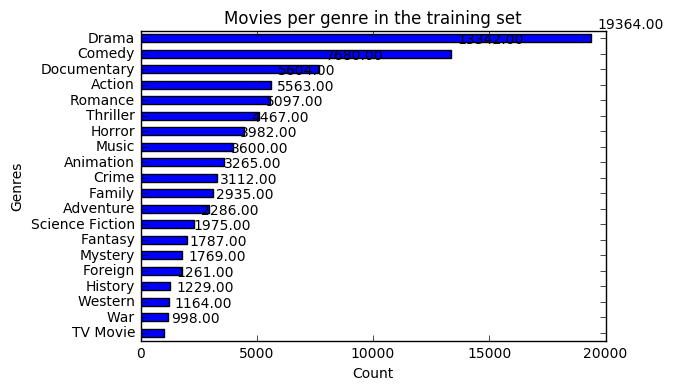

In [14]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

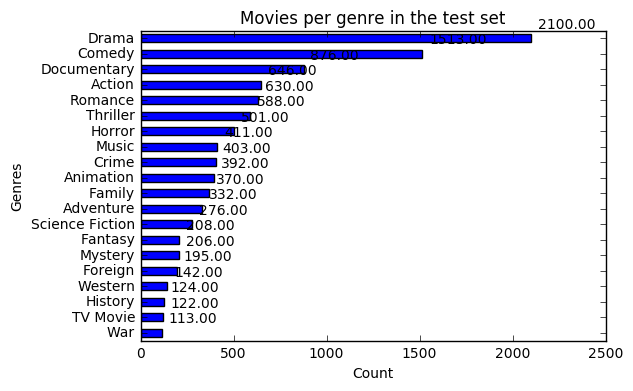

In [15]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

### Model definition  
4 convolution layers and 2 fully conected layers regularized by the dropouts.

In [16]:
def get_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))
   
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation = 'sigmoid'))
    return model

In [17]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       73856     
__________

In [18]:
# custom loss
loss = wrapped_partial(weighted_crossentropy, weight = K.variable(np.array([class_weight])))

In [19]:
# rough tuning
model.compile(optimizer = 'nadam', loss = loss, metrics=['accuracy'])

In [20]:
# stop when vaidation loss is not going down for 5 epochs
earlyStopping = EarlyStopping(
    monitor='val_loss', patience = 5, min_delta = 0.01, verbose = 0, mode = 'min')

In [21]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size = 128, 
    epochs = 50, 
    verbose = 1,
    validation_split = 0.2, # 20% reserved for held-out validation data
    callbacks = [earlyStopping]
)

Train on 42353 samples, validate on 10589 samples
Epoch 1/50
42353/42353 [==============================] - 201s - loss: 29.2334 - acc: 0.2475 - val_loss: 26.8549 - val_acc: 0.2822
Epoch 2/50
42353/42353 [==============================] - 199s - loss: 27.0571 - acc: 0.2710 - val_loss: 26.5328 - val_acc: 0.2860
Epoch 3/50
42353/42353 [==============================] - 199s - loss: 26.6051 - acc: 0.2780 - val_loss: 26.2380 - val_acc: 0.2960
Epoch 4/50
42353/42353 [==============================] - 200s - loss: 26.0216 - acc: 0.2874 - val_loss: 25.5693 - val_acc: 0.2984
Epoch 5/50
42353/42353 [==============================] - 200s - loss: 24.9322 - acc: 0.2987 - val_loss: 24.8196 - val_acc: 0.2927
Epoch 6/50
42353/42353 [==============================] - 201s - loss: 22.6512 - acc: 0.3098 - val_loss: 23.2484 - val_acc: 0.3142
Epoch 7/50
42353/42353 [==============================] - 199s - loss: 19.5502 - acc: 0.3208 - val_loss: 22.0401 - val_acc: 0.3185
Epoch 8/50
42353/42353 [=========

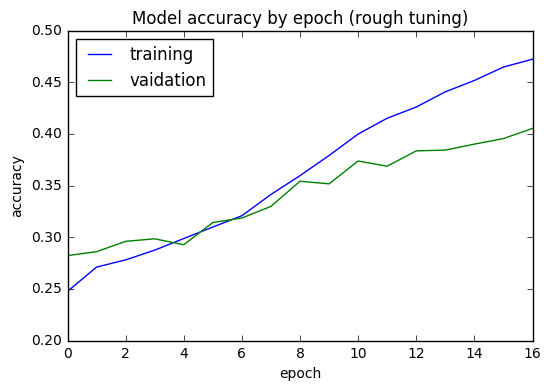

In [22]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.title('Model accuracy by epoch (rough tuning)')

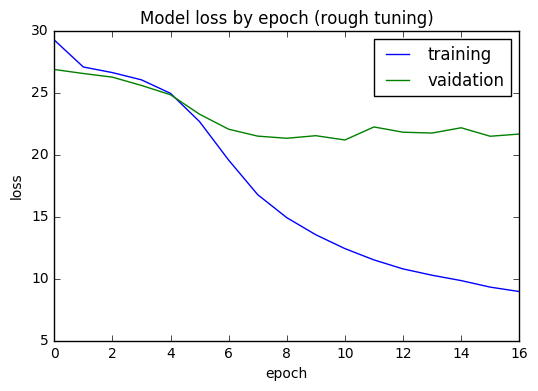

In [23]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title('Model loss by epoch (rough tuning)')

In [24]:
model.save('models/multi_cnn.h5')

In [25]:
# precise tuning with small step size
model.compile(
    optimizer=SGD(lr = 0.0001, momentum=0.9), 
    loss=loss, 
    metrics=['accuracy'])

In [26]:
history = model.fit(
    X_train, 
    y_train, 
    class_weight = class_weight,
    batch_size = 128,
    epochs = 50, 
    verbose = 1,
    validation_split = 0.2, # 20% reserved for held-out validation data
    callbacks = [earlyStopping]
)

Train on 42353 samples, validate on 10589 samples
Epoch 1/50
42353/42353 [==============================] - 193s - loss: 8.2602 - acc: 0.4908 - val_loss: 22.9958 - val_acc: 0.4061
Epoch 2/50
42353/42353 [==============================] - 193s - loss: 8.1682 - acc: 0.4921 - val_loss: 22.6224 - val_acc: 0.4049
Epoch 3/50
42353/42353 [==============================] - 194s - loss: 8.0836 - acc: 0.4962 - val_loss: 22.3252 - val_acc: 0.4085
Epoch 4/50
42353/42353 [==============================] - 193s - loss: 8.0236 - acc: 0.4935 - val_loss: 22.4447 - val_acc: 0.4104
Epoch 5/50
42353/42353 [==============================] - 194s - loss: 8.0095 - acc: 0.4960 - val_loss: 23.0202 - val_acc: 0.4064
Epoch 6/50
42353/42353 [==============================] - 193s - loss: 7.8920 - acc: 0.4957 - val_loss: 22.5949 - val_acc: 0.4095
Epoch 7/50
42353/42353 [==============================] - 194s - loss: 7.9186 - acc: 0.4991 - val_loss: 22.5140 - val_acc: 0.4104
Epoch 8/50
42353/42353 [================

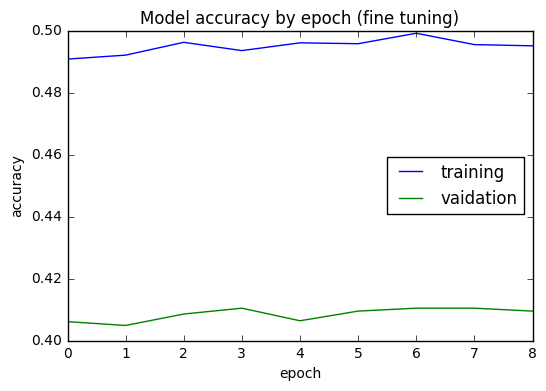

In [27]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.title('Model accuracy by epoch (fine tuning)')

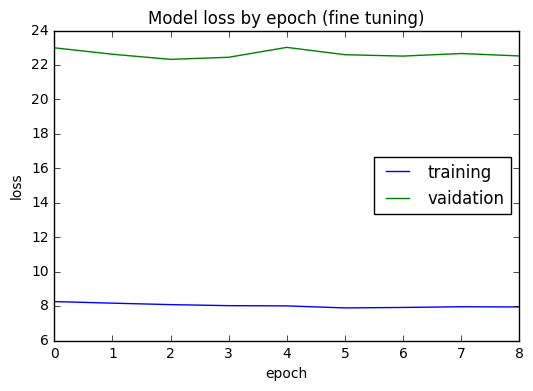

In [28]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title('Model loss by epoch (fine tuning)')

In [29]:
model.save('models/multi_cnn.h5')

In [30]:
# model performance on the test set
y_pred_proba = model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [31]:
print(classification_report(y_test, y_pred_test, target_names = mlb.classes_))

                 precision    recall  f1-score   support

         Action       0.82      0.25      0.38       646
      Adventure       0.95      0.44      0.60       332
      Animation       0.87      0.53      0.66       392
         Comedy       0.62      0.33      0.43      1513
          Crime       0.84      0.36      0.51       403
    Documentary       0.65      0.42      0.51       876
          Drama       0.59      0.36      0.44      2100
         Family       0.91      0.51      0.65       370
        Fantasy       0.98      0.56      0.71       208
        Foreign       0.98      0.50      0.66       195
        History       1.00      0.52      0.69       124
         Horror       0.79      0.39      0.52       501
          Music       0.85      0.53      0.65       411
        Mystery       0.97      0.46      0.63       206
        Romance       0.82      0.27      0.41       630
Science Fiction       0.95      0.48      0.64       276
       TV Movie       1.00    

In [32]:
# save test data so we can evaluate performance again
with open('models/multi_cnn_test.pickle', 'wb') as handle:
    pickle.dump((X_test, y_test), handle, protocol = pickle.HIGHEST_PROTOCOL)